### **Transit Optimisation**  (By Naman Goel)

Mainly the two types of problems are faced:



1.   Increased ride hailing competition which is a direct result of improper transit network of public transportation which has led to the decrease in its ridership.
2.   Increased cost of transportation operations as the decrease in ridership of public transit has resulted in less revenue whereas the operation cost lies the same. 


Approach:

A new set of transit stops are initialised using block-level population data from the 2010 census by assigning weights to each intersection according to the population in its surrounding blocks. The population served by the current and proposed stops are then compared. 




### Installing and importing required libraries and packages

In [ ]:

!pip install geopandas
!pip install osmnx==1.1.2
!pip install mapclassify

import requests, zipfile, io, os
import pandas as pd
import numpy
import geopandas
from shapely.geometry import Point
from geopandas import GeoSeries
import json
import osmnx as ox
from shapely.ops import cascaded_union



     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 38.2 MB/s 
     |████████████████████████████████| 16.7 MB 34.8 MB/s 
     |████████████████████████████████| 95 kB 2.4 MB/s 
     |████████████████████████████████| 63 kB 881 kB/s 
     |████████████████████████████████| 11.2 MB 32.2 MB/s 
     |████████████████████████████████| 1.0 MB 32.5 MB/s 
     |████████████████████████████████| 900 kB 34.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires reque

In [ ]:
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt

     |████████████████████████████████| 13.1 MB 5.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osmnx 1.1.2 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Extraction using an API ( Getting Population Data by Census City Block )**

Examining data of Austin, Texas

In [ ]:
#key that will used to download data from API ( API key to US Census )

def census_API_key():           
    return 'c473f07bbf5a277c05596ddb13c831d72cc0311d'

In [ ]:
#function to get population data by census block ( takes inputs : state FIPS code, FIPS county code and API key -> output pandas dataframe )

def makeAPI_PopByBlock2010(state, county,  key):
   
    base_url = 'https://api.census.gov/data/2010/dec/sf1'
    query_call = '?get=P001001'
    geo_call = ',NAME&for=block:*&in=state:{}%in=county:{}&'.format(state,county)
    key_call = 'key={}'.format(key)
    URL = base_url + query_call + geo_call + key_call
    response = requests.get(URL).json()
    data = response[1:]
    labels = response[0]
    
    # Create pandas DataFrame
    df = pd.DataFrame(data=data, columns=labels)
    # Rename population column
    df.rename(columns={'P001001': 'population'}, inplace=True)
    # Create 'ID' column and set index
    df['ID'] = df.state + df.county + df.tract + df.block
    df.set_index('ID', inplace=True)
      
    return df

    #example URL:
    # https://api.census.gov/data/2000/dec/sf1?get=P001001,NAME&for=block:*&in=state:04%20county:005&key=YOUR_KEY_GOES_HERE

In [ ]:
#state FIPS code and County FIPS code

key = census_API_key()
state = 48
county = 453

In [ ]:
df = makeAPI_PopByBlock2010(state, county, key)
df.head()

,population,NAME,state,county,tract,block
ID,,,,,,
484530001011008,65,"Block 1008, Block Group 1, Census Tract 1.01, ...",48,453,000101,1008
484530001011011,109,"Block 1011, Block Group 1, Census Tract 1.01, ...",48,453,000101,1011
484530001011012,29,"Block 1012, Block Group 1, Census Tract 1.01, ...",48,453,000101,1012
484530001011000,47,"Block 1000, Block Group 1, Census Tract 1.01, ...",48,453,000101,1000
484530001011001,0,"Block 1001, Block Group 1, Census Tract 1.01, ...",48,453,000101,1001


In [ ]:
df=df.drop(labels='NAME', axis=1)

In [ ]:
type(df.population[0])

str

In [ ]:
df['population'] = df.population.astype('int')
type(df.population[0])

numpy.int64

In [ ]:
df.shape

(15922, 5)

## Downloading Block-level shapefiles for State and Joining DataFrames

The downloaded data includes census block shapes for the entire state specified.

In [ ]:
#function to download Block-level shapefiles for State ( takes inputs : state FIPS code -> outputs newpath )

def Download_Unzip_GEOs(state):

    # download zip file and extract to a local 'data' folder
    url = 'https://www2.census.gov/geo/tiger/TIGER2017/TABBLOCK/' + 'tl_2017_{}_tabblock10.zip'.format(state)
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    new_path = '/content/drive/MyDrive/Traffic_optimisation/block_{}'.format(state)
    if not os.path.exists(new_path):
        os.makedirs(new_path)
    z.extractall(new_path)
    
    return new_path

In [ ]:
#function to Join DataFrames ( takes inputs :  string(path to blockGEOs), DataFrame returned by 'makeAPI_PopByBlock2010'  -> outputs: Dataframe )

def joinDFs(path_blockGEOs, df):
    
    # create a geo-pandas DataFrame and filter the columns for only ID and 'geometry'
    geo_df = geopandas.read_file(path_blockGEOs)
    geo_df = geo_df[['GEOID10','geometry']]
    geo_df.set_index('GEOID10', inplace=True)
    joined_df = geo_df.join(df, how='right')
    print('GeoDataFrame with projection = {}'.format(joined_df.crs))

    return joined_df

In [ ]:
newpath=Download_Unzip_GEOs(state)
newpath

'/content/drive/MyDrive/Traffic_optimisation/block_48'

In [ ]:
BlockGeoPath = newpath
df = joinDFs(BlockGeoPath, df)

GeoDataFrame with projection = epsg:4269


In [ ]:
df.head()

,geometry,population,state,county,tract,block
ID,,,,,,
484530001011008,"POLYGON ((-97.74833 30.32624, -97.74779 30.325...",65,48,453,000101,1008
484530001011011,"POLYGON ((-97.75348 30.32057, -97.75192 30.323...",109,48,453,000101,1011
484530001011012,"POLYGON ((-97.75068 30.32516, -97.75022 30.325...",29,48,453,000101,1012
484530001011000,"POLYGON ((-97.75546 30.33233, -97.75530 30.333...",47,48,453,000101,1000
484530001011001,"POLYGON ((-97.75538 30.33539, -97.75530 30.335...",0,48,453,000101,1001


### Texas North Central measurements in U.S. FEET

In [ ]:
NAD83 = {'init': 'EPSG:2277'} 
LatLong = {'init': 'EPSG:4326'}
df = df.to_crs(NAD83)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
df.crs

<Projected CRS: EPSG:2277>
Name: NAD83 / Texas Central (ftUS)
Axis Info [cartesian]:
- E[east]: Easting (US survey foot)
- N[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Texas - counties of Anderson; Angelina; Bastrop; Bell; Blanco; Bosque; Brazos; Brown; Burleson; Burnet; Cherokee; Coke; Coleman; Comanche; Concho; Coryell; Crane; Crockett; Culberson; Ector; El Paso; Falls; Freestone; Gillespie; Glasscock; Grimes; Hamilton; Hardin; Houston; Hudspeth; Irion; Jasper; Jeff Davis; Kimble; Lampasas; Lee; Leon; Liberty; Limestone; Llano; Loving; Madison; Mason; McCulloch; McLennan; Menard; Midland; Milam; Mills; Montgomery; Nacogdoches; Newton; Orange; Pecos; Polk; Reagan; Reeves; Robertson; Runnels; Sabine; San Augustine; San Jacinto; San Saba; Schleicher; Shelby; Sterling; Sutton; Tom Green; Travis; Trinity; Tyler; Upton; Walker; Ward; Washington; Williamson; Winkler.
- bounds: (-106.66, 29.78, -93.5, 32.27)
Coordinate Operation:
- name: SPCS83 Texas Central

#### Restricting Area of Analysis as the East Side of Austin, Texas

In [ ]:
AoA_tracts = ['001000','000902','000901','000804','000801','000802','000803','002109','002110','002111']
AoA_df = df[(df.tract.isin(AoA_tracts))]

In [ ]:
AoA_df.head()

,geometry,population,state,county,tract,block
ID,,,,,,
484530008011009,"POLYGON ((3126135.516 10070477.953, 3126176.76...",104,48,453,000801,1009
484530008011001,"POLYGON ((3126259.906 10072617.075, 3126775.75...",54,48,453,000801,1001
484530008011005,"POLYGON ((3127483.151 10071190.475, 3127639.80...",142,48,453,000801,1005
484530008011007,"POLYGON ((3128482.667 10070693.923, 3128592.72...",25,48,453,000801,1007
484530008011010,"POLYGON ((3125147.284 10070337.112, 3125325.66...",75,48,453,000801,1010


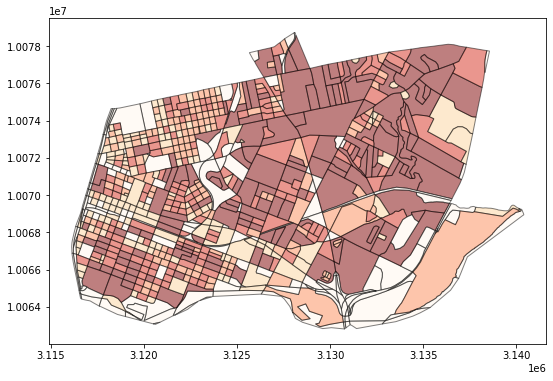

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set_aspect('equal')
AoA_df.plot(ax=ax, column='population', cmap='OrRd', edgecolor='black', alpha=.5, scheme='quantiles')
plt.show()

#Making A boundary of the Area of Analysis

In [ ]:
def makeBoundary(df, crs):
    polygons = []
    for geo in df[['geometry']].values:
        polygons.append(geo[0])
    boundary = GeoSeries(cascaded_union(polygons))
    boundary.crs = crs
    
    return boundary

In [ ]:
AoA_geo = makeBoundary(AoA_df, NAD83)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  """
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


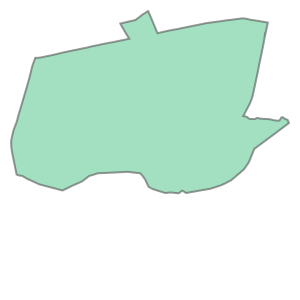

In [ ]:
AoA_geo[0]

### Defining a boundary in LatLong Coordinates

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


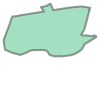

In [ ]:
AoA_LatLong = AoA_geo.to_crs(LatLong)
AoA_LatLong_geo = AoA_LatLong.geometry[0]
AoA_LatLong_geo

## Getting Intersections

In [ ]:
 # function to get intersections of roads in area of Analysis
    # INPUT:  boundary shape, projection in UTM, int (in meters) representing tolerance of clean_intersections() function for osmnx package
    # OUTPUT: GeoSeries of Intersections

    
def getIntersections(boundary, projection, tolerance=100):
    # Create Graph
    G = ox.graph_from_polygon(boundary, network_type='drive')
    ox.plot_graph(G)
    plt.show()

    # Clean Intersections
    G_proj = ox.project_graph(G, to_crs=projection)
    intersections = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=tolerance, dead_ends=False)

    return intersections

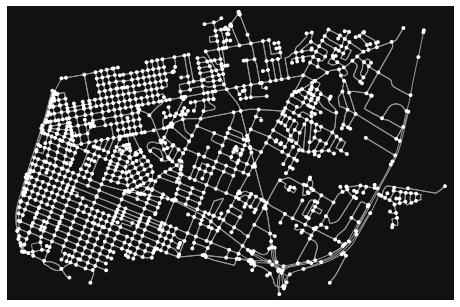

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
intersections = getIntersections(AoA_LatLong_geo, NAD83)

In [ ]:
type(intersections)

geopandas.geoseries.GeoSeries

In [ ]:
intersections

0      POINT (3117831.216 10064647.510)
1      POINT (3117224.946 10064915.091)
2      POINT (3116942.928 10065057.655)
3      POINT (3116675.186 10065125.837)
4      POINT (3117197.688 10065131.382)
                     ...               
823    POINT (3134861.106 10077358.232)
824    POINT (3135060.507 10077537.106)
825    POINT (3134280.690 10077564.143)
826    POINT (3138376.147 10077692.934)
827    POINT (3137259.603 10077842.142)
Length: 828, dtype: geometry

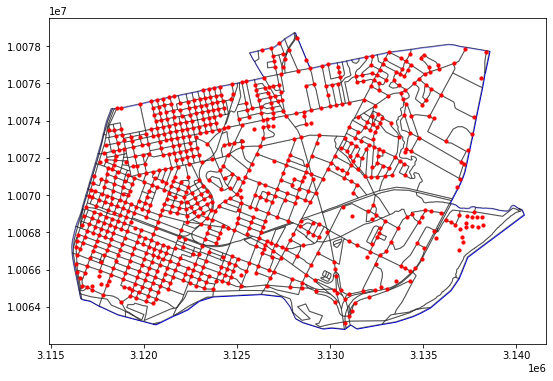

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
intersections.plot(ax=ax, color='red', markersize=10)
plt.show()

# Defining a Metrics to assign Weight to each Intersection
## Finding all the census blocks connected to an intersection and summing up their populations.

### Population Distribution

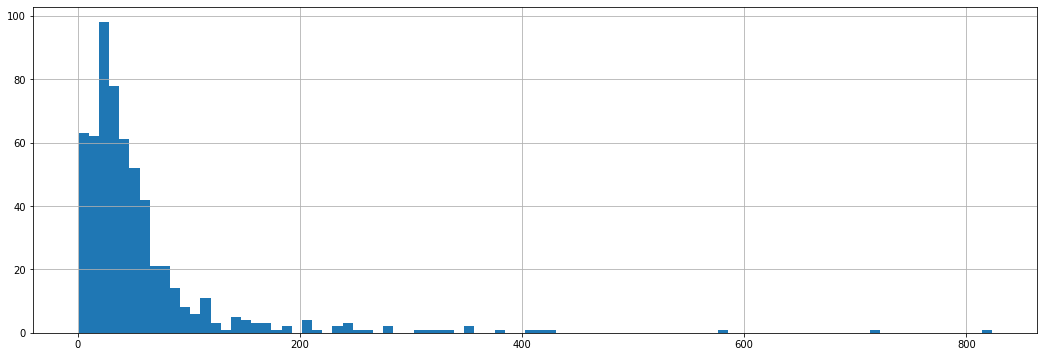

In [ ]:
fig, ax = plt.subplots(figsize=(18,6))
AoA_df.population[AoA_df.population != 0].hist(bins=90)
plt.show()

Converting to GeoPandas DataFrame

In [ ]:
intersections_df = geopandas.GeoDataFrame(intersections, columns=['geometry'], crs=NAD83)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
intersections_df.head()

,geometry
0,POINT (3117831.216 10064647.510)
1,POINT (3117224.946 10064915.091)
2,POINT (3116942.928 10065057.655)
3,POINT (3116675.186 10065125.837)
4,POINT (3117197.688 10065131.382)


# **Blocks Per Intersection**
 (List of Blocks within buffer distance of intersection)

In [ ]:
def BlockList(IntersectionGeo, AoA_df, buffer=200):
   
    blocks_df = AoA_df[['geometry', 'population']]
    intersection = IntersectionGeo.buffer(200)                                          #search for all blocks within 200 meters (or about 0.124 miles)
    blockList = []
    iPop = 0 
    for row in range(blocks_df.shape[0]):
        geo = blocks_df.iloc[row]['geometry']
        pop = blocks_df.iloc[row]['population']
        if geo.intersects(intersection) == True:
            blockList.append(geo)
            iPop += pop
    
    return blockList , iPop

In [ ]:
# INPUT:  AoA_df: GeoDataFrame of Area of Interest
#         ** intersections_df: GeoDataFrame of intersections 
# OUTPUT: intersections_df: GeoDataFrame with new columns added ('bList', 'iPop')
#         ** bList is a list of blocks near each intersection, iPop is a population count assigned to each intersection

def BlocksPerIntersection(intersections_df, AoA_df):
   
    blockArray = []
    popArray = []
    for intersection in intersections_df.geometry:
        blockList, intersectionPop = BlockList(intersection, AoA_df)
        blockArray.append(blockList)
        popArray.append(intersectionPop)

    intersections_df['bList'] = blockArray
    intersections_df['iPop'] = popArray

    return intersections_df

In [ ]:
intersections_df = BlocksPerIntersection(intersections_df, AoA_df)

In [ ]:
intersections_df.head()

,geometry,bList,iPop
0,POINT (3117831.216 10064647.510),[POLYGON ((3116687.5329924873 10065400.4905129...,383
1,POINT (3117224.946 10064915.091),[POLYGON ((3116687.5329924873 10065400.4905129...,306
2,POINT (3116942.928 10065057.655),[POLYGON ((3116687.5329924873 10065400.4905129...,306
3,POINT (3116675.186 10065125.837),[POLYGON ((3116687.5329924873 10065400.4905129...,306
4,POINT (3117197.688 10065131.382),[POLYGON ((3116687.5329924873 10065400.4905129...,306


# Zero Population Intersections

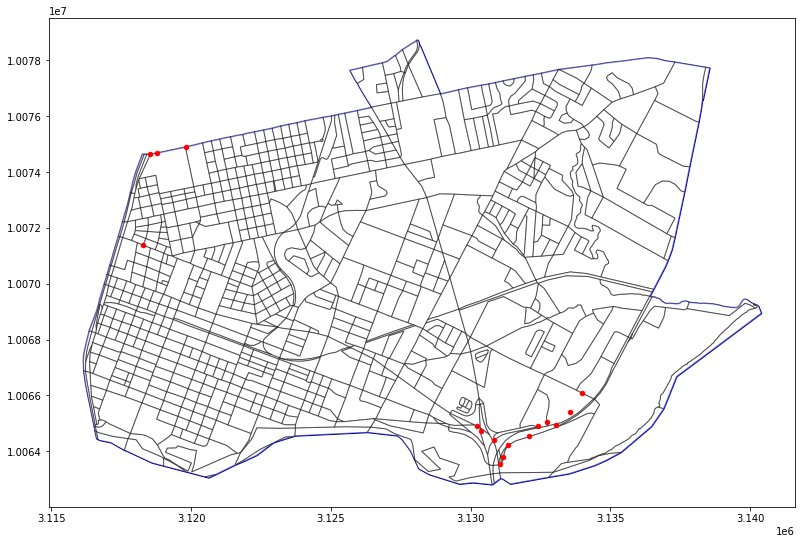

In [ ]:
fig, ax = plt.subplots(figsize=(18,9))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
intersections_df[intersections_df.iPop == 0].geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

# High Population Intersections


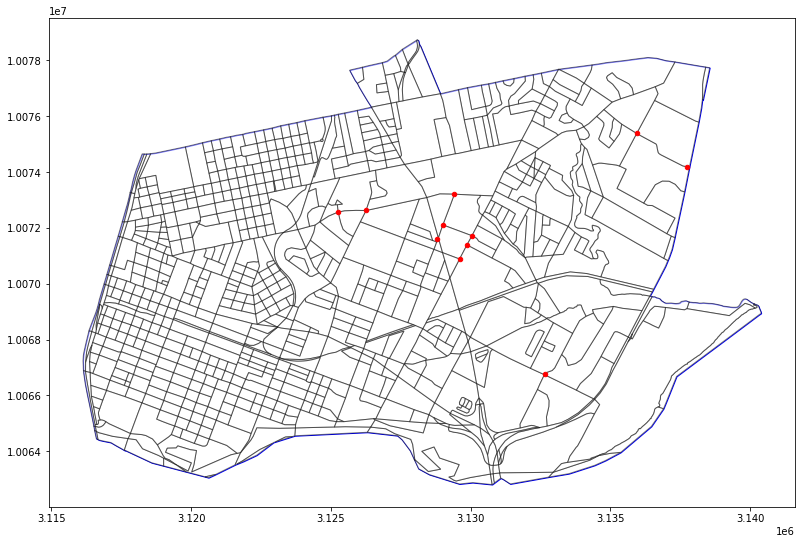

In [ ]:
fig, ax = plt.subplots(figsize=(18,9))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
intersections_df[intersections_df.iPop > 800].geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

# Determining the Transit Stop Locations

In [ ]:
def MakeStops(intersections_df, meters=800):
    
    # Sort the DataFrame in order of descending population
    iPop_df = intersections_df[intersections_df.iPop > 0].sort_values('iPop', ascending=False)
    indexList = []
    served = [] # population served at each bus stop identified
    while iPop_df.shape[0] != 0:
        stop = iPop_df.geometry.values[0]
        idx = iPop_df.index.values[0]
        indexList.append(idx)
        # identify the exclusion zone
        zone = stop.buffer(meters) # 400 meters = approx 1/4 mile
        # reach is the sum of all populations in the exclusion zone
        reach = iPop_df[iPop_df.geometry.intersects(zone) == True].iPop.sum()
        served.append([idx, reach])
        #filter out any intersections within exclusion zone
        iPop_df = iPop_df[iPop_df.geometry.intersects(zone) == False]

    stops_df = intersections_df[intersections_df.index.isin(indexList)]

    # convert the 'served' array into a DataFrame
    served_df = pd.DataFrame(data=served, columns=['idx','mergedPop'], dtype='int')
    served_df.set_index('idx', inplace=True)
    
    # Merge DataFrames
    stops_df = stops_df.merge(served_df, left_index=True, right_index=True)

    return stops_df


In [ ]:
stops_df = MakeStops(intersections_df)
stops_df.head()

,geometry,bList,iPop,mergedPop
0,POINT (3117831.216 10064647.510),[POLYGON ((3116687.5329924873 10065400.4905129...,383,995
3,POINT (3116675.186 10065125.837),[POLYGON ((3116687.5329924873 10065400.4905129...,306,612
11,POINT (3116971.872 10066176.966),[POLYGON ((3116389.679422274 10066822.13555226...,443,1674
16,POINT (3116425.816 10066791.384),[POLYGON ((3116224.400711256 10066935.05329068...,50,155
22,POINT (3117480.721 10067547.867),[POLYGON ((3117488.673561135 10067552.83630721...,274,2545


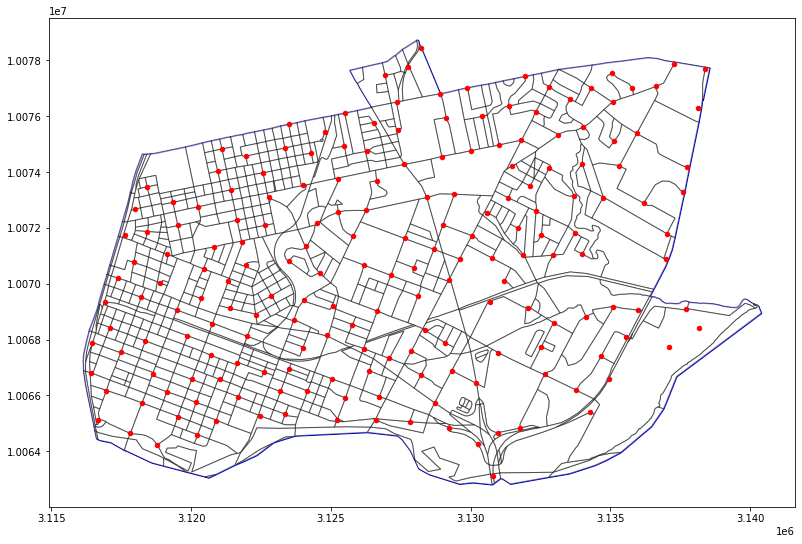

In [ ]:
fig, ax = plt.subplots(figsize=(18,9))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
stops_df.geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

# **Current Transit Stops**
## Data downloaded from https://data.texas.gov/Transportation/CapMetro-Shapefiles-JUNE-2018/rwce-6ann

In [ ]:
stopspath ='/content/drive/MyDrive/Traffic_optimisation/Stops.dbf'

In [ ]:
stops_dbf = geopandas.read_file(stopspath)
stops_dbf.head()

,STOP_ID,STOP_NAME,STOP_ABBR,STREET_NMB,ON_STREET,AT_STREET,CITY,ZIP,BAY,STOP_TYPE,PLACEMENT,CORNER,STATUS,LATITUDE,LONGITUDE,SOURCE,SOURCEDATE,geometry
0,243,Rio Grande/15th,RG15,000606,15Th,Rio Grande,Austin,78701,None,Bus Stop,Farside,Northwest,None,30.278966,-97.746339,Capital Metro,2018-05-17,None
1,466,8740 Lamar/Payton Gin,S1801,008740,LAMAR,PAYTON GIN,AUSTIN,78758,None,Bus Stop,Mid-Block,Southwest,None,30.356809,-97.701066,Capital Metro,2018-05-17,None
2,467,8630 Lamar/Fairfield,S63,008630,LAMAR,FAIRFIELD,AUSTIN,78758,None,Bus Stop,Farside,Southwest,None,30.355296,-97.703128,Capital Metro,2018-05-17,None
3,468,Lamar/Thurmond,S15,008400,LAMAR,THURMOND,AUSTIN,78758,None,Bus Stop,Farside,Southwest,None,30.353139,-97.706082,Capital Metro,2018-05-17,None
4,469,8320 Lamar/Meadowlark,S62,008320,LAMAR,MEADOWLARK,AUSTIN,78758,None,Bus Stop,Nearside,Northwest,None,30.352256,-97.707295,Capital Metro,2018-05-17,None


In [ ]:
AoA_geo=AoA_geo.to_crs(LatLong)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
bounds = AoA_geo.bounds
bounds

,minx,miny,maxx,maxy
0,-97.737298,30.245176,-97.660341,30.289089


In [ ]:
from shapely.geometry import Point
stops_dbf['Coordinates'] = list(zip(stops_dbf.LONGITUDE, stops_dbf.LATITUDE))

In [ ]:
stops_dbf['Coordinates'] = stops_dbf['Coordinates'].apply(Point)

In [ ]:
gdf = geopandas.GeoDataFrame(stops_dbf, geometry='Coordinates')

In [ ]:
gdf.shape

(2404, 19)

In [ ]:
gdf=gdf[gdf.Coordinates.within(AoA_geo[0])]

In [ ]:
gdf.head()

,STOP_ID,STOP_NAME,STOP_ABBR,STREET_NMB,ON_STREET,AT_STREET,CITY,ZIP,BAY,STOP_TYPE,PLACEMENT,CORNER,STATUS,LATITUDE,LONGITUDE,SOURCE,SOURCEDATE,geometry,Coordinates
85,634,3200 Oak Springs/Airport,84SB,003200,OAK SPRINGS,AIRPORT,AUSTIN,78702,None,Bus Stop,Farside,Northwest,None,30.273610,-97.698350,Capital Metro,2018-05-17,None,POINT (-97.69835 30.27361)
86,635,Oak Springs/Ridgeway,S1854,002700,OAK SPRINGS,RIDGEWAY,AUSTIN,78702,None,Bus Stop,Nearside,Northeast,None,30.272556,-97.704568,Capital Metro,2018-05-17,None,POINT (-97.70457 30.27256)
87,636,2600 Rosewood/Ridgeway,S1855,002600,ROSEWOOD,RIDGEWAY,AUSTIN,78702,None,Bus Stop,Mid-Block,Northwest,None,30.272509,-97.706241,Capital Metro,2018-05-17,None,POINT (-97.70624 30.27251)
88,637,2420 Rosewood/Bedford,S612,002420,ROSEWOOD,BEDFORD,AUSTIN,78702,None,Bus Stop,Farside,Northwest,None,30.272319,-97.708296,Capital Metro,2018-05-17,None,POINT (-97.70830 30.27232)
89,638,2370 Rosewood/Hargrave,S614,002370,ROSEWOOD,HARGRAVE,AUSTIN,78702,None,Bus Stop,Mid-Block,Northwest,None,30.271236,-97.710649,Capital Metro,2018-05-17,None,POINT (-97.71065 30.27124)


In [ ]:
gdf.shape

(246, 19)

In [ ]:
AoA_df.crs


<Projected CRS: EPSG:2277>
Name: NAD83 / Texas Central (ftUS)
Axis Info [cartesian]:
- E[east]: Easting (US survey foot)
- N[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Texas - counties of Anderson; Angelina; Bastrop; Bell; Blanco; Bosque; Brazos; Brown; Burleson; Burnet; Cherokee; Coke; Coleman; Comanche; Concho; Coryell; Crane; Crockett; Culberson; Ector; El Paso; Falls; Freestone; Gillespie; Glasscock; Grimes; Hamilton; Hardin; Houston; Hudspeth; Irion; Jasper; Jeff Davis; Kimble; Lampasas; Lee; Leon; Liberty; Limestone; Llano; Loving; Madison; Mason; McCulloch; McLennan; Menard; Midland; Milam; Mills; Montgomery; Nacogdoches; Newton; Orange; Pecos; Polk; Reagan; Reeves; Robertson; Runnels; Sabine; San Augustine; San Jacinto; San Saba; Schleicher; Shelby; Sterling; Sutton; Tom Green; Travis; Trinity; Tyler; Upton; Walker; Ward; Washington; Williamson; Winkler.
- bounds: (-106.66, 29.78, -93.5, 32.27)
Coordinate Operation:
- name: SPCS83 Texas Central

In [ ]:
AoA_df.to_crs(LatLong)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry,population,state,county,tract,block
ID,,,,,,
484530008011009,"POLYGON ((-97.70538 30.26655, -97.70524 30.267...",104,48,453,000801,1009
484530008011001,"POLYGON ((-97.70483 30.27242, -97.70319 30.272...",54,48,453,000801,1001
484530008011005,"POLYGON ((-97.70106 30.26842, -97.70053 30.269...",142,48,453,000801,1005
484530008011007,"POLYGON ((-97.69793 30.26699, -97.69756 30.267...",25,48,453,000801,1007
484530008011010,"POLYGON ((-97.70852 30.26622, -97.70793 30.267...",75,48,453,000801,1010
...,...,...,...,...,...,...
484530021113020,"POLYGON ((-97.67525 30.25927, -97.67500 30.259...",0,48,453,002111,3020
484530021113018,"POLYGON ((-97.68532 30.25863, -97.68497 30.259...",10,48,453,002111,3018
484530021113019,"POLYGON ((-97.68663 30.25652, -97.68532 30.258...",167,48,453,002111,3019


In [ ]:
gdf.crs=LatLong
gdf=gdf.to_crs(NAD83)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
AoA_geo=AoA_geo.to_crs(NAD83)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


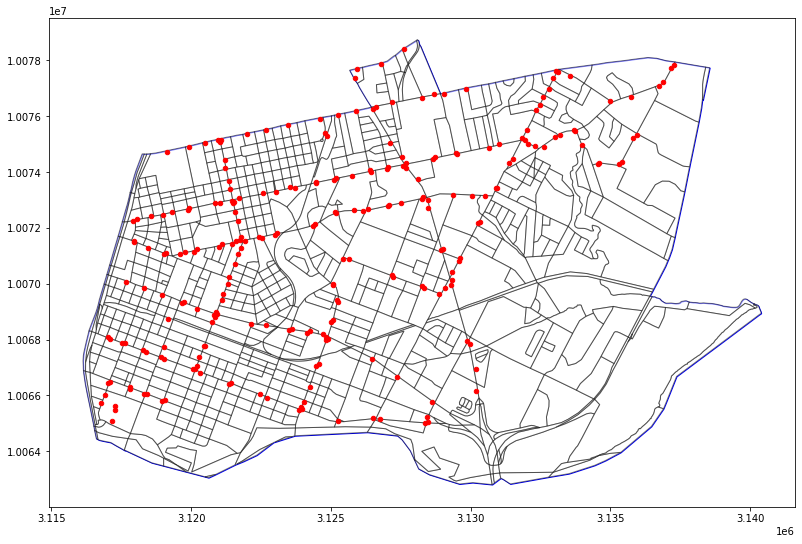

In [ ]:
fig, ax = plt.subplots(figsize=(18,9))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
gdf.Coordinates.plot(ax=ax, color='red', markersize=20)
plt.show()

## Population Distribution Served by each stop

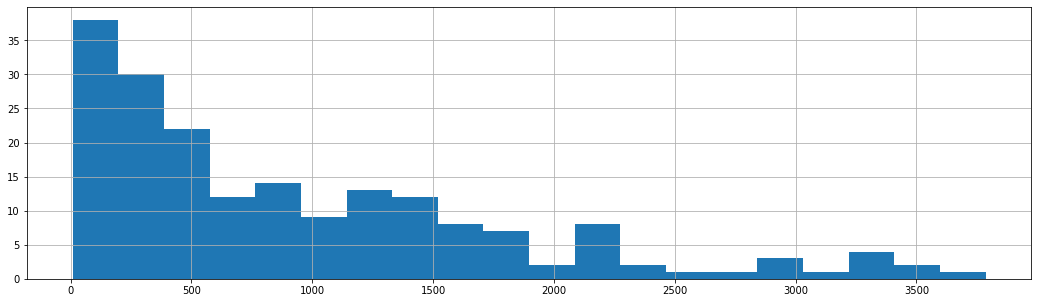

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
stops_df.mergedPop.hist(bins=20)
plt.show()

In [ ]:
def filterStops(CurrentStops_df, stops_df):
    goalNum = CurrentStops_df.shape[0]/2
    minPop = stops_df.mergedPop.min()
    maxPop = stops_df.mergedPop.max()
    for bench in range(minPop, maxPop):
        filterStops = stops_df[stops_df.mergedPop > bench]
        if filterStops.shape[0] <= goalNum:
            return filterStops, bench

In [ ]:
filterStops_df, bench = filterStops(gdf, stops_df)

In [ ]:
filterStops_df.head()

,geometry,bList,iPop,mergedPop
0,POINT (3117831.216 10064647.510),[POLYGON ((3116687.5329924873 10065400.4905129...,383,995
3,POINT (3116675.186 10065125.837),[POLYGON ((3116687.5329924873 10065400.4905129...,306,612
11,POINT (3116971.872 10066176.966),[POLYGON ((3116389.679422274 10066822.13555226...,443,1674
22,POINT (3117480.721 10067547.867),[POLYGON ((3117488.673561135 10067552.83630721...,274,2545
33,POINT (3117088.031 10068423.623),[POLYGON ((3116891.8834083164 10068873.9948864...,209,697


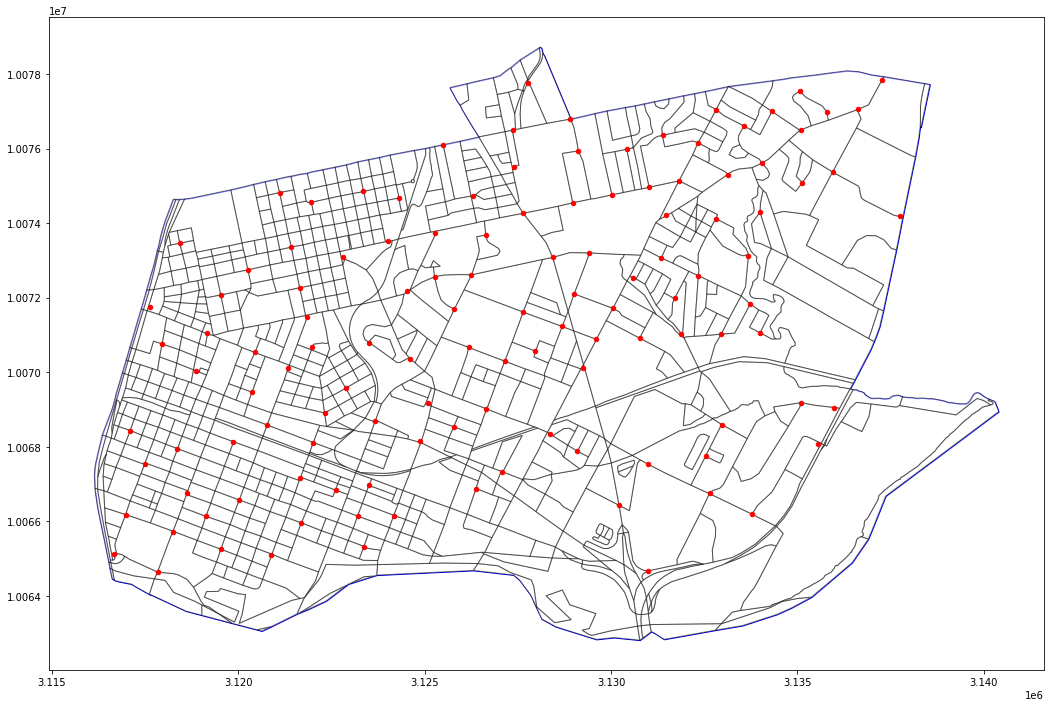

In [ ]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
filterStops_df.geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

# Finding nearest intersection

In [ ]:
def findNearestIntersection(lat, long, stops_df, crs):
  
    stationPoint = Point(lat, long)
    stationPoint.crs = {'init': 'EPSG:4326'}
    # Convert to GeoPandas so we can re-project crs to NAD83
    stationPoint = geopandas.GeoSeries(stationPoint, crs={'init': 'EPSG:4326'})
    stationPoint = stationPoint.to_crs(crs)
    
    for stop in stops_df.geometry:
        zone = stop.buffer(50)
        if stop.intersects(zone):
            return stop
        
    return 'No Stop Found'
        
    

In [ ]:
lat, long = 30.270043, -97.731517
station = findNearestIntersection(lat, long, stops_df, NAD83)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
RegionPop = AoA_df.population.sum()
print('Region Population: ', RegionPop)

Region Population:  33184


# Poupulation Within 1/4 mile

In [ ]:
def Population(stops_df, AoA_df):

    population = 0
    # iterate through stops
    while stops_df.shape[0] != 0:
        stop = stops_df.geometry.values[0]
        # Define are within 400 meters of stop
        buffer400 = stop.buffer(400)
        # filter blocks in buffer range
        blocks_df = AoA_df[AoA_df.geometry.intersects(buffer400) == True]
        # Find fractional area of buffer over block
        blocks_df['fractionalArea'] = blocks_df.geometry.intersection(buffer400).area / blocks_df.geometry.area
        # Find fractional population
        blocks_df['fractionalPop'] = blocks_df.population * blocks_df.fractionalArea
        # Add population
        population += blocks_df.fractionalPop.sum()
        # Filter CurrentStops_df to reduce population duplicates
        buffer200 = stop.buffer(200)
        stops_df = stops_df[stops_df.geometry.intersects(buffer200) == False]
    
    return int(population)

In [ ]:
CurrentPop = Population(gdf, AoA_df)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [ ]:
ProposedPop = Population(stops_df, AoA_df)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [ ]:
CurrentMetric = round(CurrentPop/RegionPop,2)
ProposedMetric = round(ProposedPop/RegionPop,2)
print('Current:', CurrentMetric*100,'% of the population is within 1/4 mile of a bus stop')
print('Proposed:', ProposedMetric*100,'%of the population is within 1/4 mile of a bus stop')

Current: 37.0 % of the population is within 1/4 mile of a bus stop
Proposed: 45.0 %of the population is within 1/4 mile of a bus stop


# Finding Optimal Route between two Stops

In [ ]:
filterStops_df=filterStops_df.geometry
filterStops_df=filterStops_df.reset_index()
filterStops_df=filterStops_df.drop(labels='index', axis=1)
filterStops_df = filterStops_df.to_crs(LatLong)
filterStops_df.crs

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

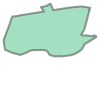

In [ ]:
AoA_LatLong_geo

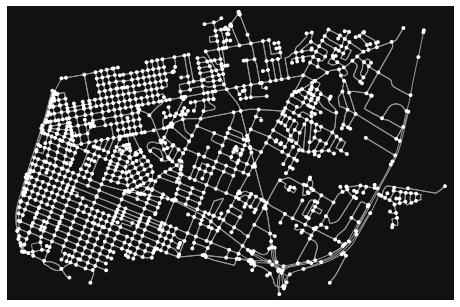

In [ ]:
# Create Graph
G = ox.graph_from_polygon(AoA_LatLong_geo, network_type='drive')
ox.plot_graph(G)
plt.show()

In [ ]:
# define a lat-long point, create network around point, define origin/destination nodes
origin_point = filterStops_df.geometry[0]
print(filterStops_df.geometry[0])
origin_xy = (origin_point.y, origin_point.x)
origin_node = ox.get_nearest_node(G, origin_xy)

POINT (-97.7321125 30.251056700000007)


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


In [ ]:
destination_point = filterStops_df.geometry[100]
print(filterStops_df.geometry[100])
destination_xy = (destination_point.y, destination_point.x)
destination_node = ox.get_nearest_node(G, destination_xy)


POINT (-97.68288340000001 30.279349200000024)


/usr/local/lib/python3.7/dist-packages/osmnx/distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


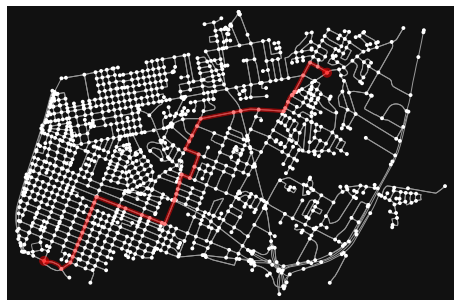

In [ ]:
import networkx as nx
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route)

In [ ]:
print(nx.shortest_path_length(G,source=origin_node,target=destination_node))

46


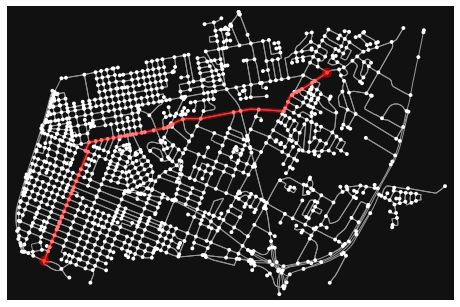

In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
fig, ax = ox.plot_graph_route(G, route)